In [33]:
%pylab inline
import re
import math
import string
from collections import Counter
from __future__ import division
import random
import numpy as np

Populating the interactive namespace from numpy and matplotlib


c:\Users\15852\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['sample', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
file = open("big.txt","r")
TEXT = file.read()
len(TEXT)

6488665

In [3]:
def tokens(text):
    "List all the word tokens (consecutive letters) in a text. Normalize to lowercase."
    return re.findall('[a-z]+', text.lower()) 

In [4]:
tokens('This is: A test, 1, 2, 3, this is.')

['this', 'is', 'a', 'test', 'this', 'is']

In [5]:
WORDS = tokens(TEXT)
len(WORDS)

1105285

In [6]:
def sample(bag, n=10):
    "Sample a random n-word sentence from the model described by the bag of words."
    return ' '.join(random.choice(bag) for _ in range(n))

In [7]:
sample(WORDS)

'please prince one run given turned cases headquarters whose only'

In [8]:
Counter(tokens('Is this a test? It is a test!'))

Counter({'is': 2, 'this': 1, 'a': 2, 'test': 2, 'it': 1})

In [9]:
COUNTS = Counter(WORDS)

print(COUNTS.most_common(10))

[('the', 80030), ('of', 40025), ('and', 38313), ('to', 28766), ('in', 22050), ('a', 21155), ('that', 12512), ('he', 12401), ('was', 11410), ('it', 10681)]


In [10]:
for w in tokens('the rare and neverbeforeseen words'):
    print(COUNTS[w], w)

80030 the
83 rare
38313 and
0 neverbeforeseen
460 words


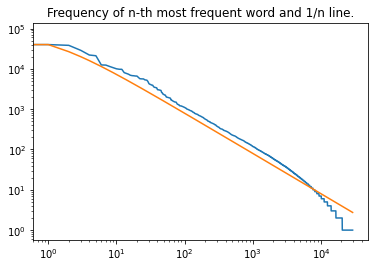

In [11]:
M = COUNTS['the']
yscale('log'); xscale('log'); title('Frequency of n-th most frequent word and 1/n line.')
plot([c for (w, c) in COUNTS.most_common()])
plot([M/i for i in range(1, len(COUNTS)+1)]);

In [12]:
def correct(word):
    "Find the best spelling correction for this word."
    # Prefer edit distance 0, then 1, then 2; otherwise default to word itself.
    candidates = (known(edits0(word)) or 
                  known(edits1(word)) or 
                  known(edits2(word)) or 
                  [word])
    return max(candidates, key=COUNTS.get)

def known(words):
    "Return the subset of words that are actually in the dictionary."
    return {w for w in words if w in COUNTS}

def edits0(word): 
    "Return all strings that are zero edits away from word (i.e., just word itself)."
    return {word}

def edits2(word):
    "Return all strings that are two edits away from this word."
    return {e2 for e1 in edits1(word) for e2 in edits1(e1)}

def edits1(word):
    "Return all strings that are one edit away from this word."
    pairs      = splits(word)
    deletes    = [a+b[1:]           for (a, b) in pairs if b]
    transposes = [a+b[1]+b[0]+b[2:] for (a, b) in pairs if len(b) > 1]
    replaces   = [a+c+b[1:]         for (a, b) in pairs for c in alphabet if b]
    inserts    = [a+c+b             for (a, b) in pairs for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def splits(word):
    "Return a list of all possible (first, rest) pairs that comprise word."
    return [(word[:i], word[i:]) 
            for i in range(len(word)+1)]

alphabet = 'abcdefghijklmnopqrstuvwxyz'

In [13]:
print(*map(correct, tokens('Speling errurs in somethink. Whutever; unusuel misteakes everyware?')))

spelling errors in something whatever unusual mistakes everywhere


In [14]:
def correct_text(text):
    "Correct all the words within a text, returning the corrected text."
    return re.sub('[a-zA-Z]+', correct_match, text)

def correct_match(match):
    "Spell-correct word in match, and preserve proper upper/lower/title case."
    word = match.group()
    return case_of(word)(correct(word.lower()))

def case_of(text):
    "Return the case-function appropriate for text: upper, lower, title, or just str."
    return (str.upper if text.isupper() else
            str.lower if text.islower() else
            str.title if text.istitle() else
            str)

# Now for a more NLP based model

In [102]:
import scipy.spatial.distance as ssd 
def pdist(counter):
    "Make a probability distribution, given evidence from a Counter."
    # N = sum(counter.values())
    # return lambda x: counter[x]/N
    N = 0
    for x in counter:
        N += counter[x]
    dictionary = {}
    for x in counter:
        dictionary[x] = counter[x] / N
    return dictionary

P = pdist(COUNTS)

In [78]:
def memo(f):
    "Memoize function f, whose args must all be hashable."
    cache = {}
    def fmemo(*args):
        if args not in cache:
            cache[args] = f(*args)
        return cache[args]
    fmemo.cache = cache
    return fmemo

In [79]:
max(len(w) for w in COUNTS)

18

In [80]:
def splits(text, start=0, L=20):
    "Return a list of all (first, rest) pairs; start <= len(first) <= L."
    return [(text[:i], text[i:]) 
            for i in range(start, min(len(text), L)+1)]

In [81]:
print(splits('word'))
print(splits('reallylongtext', 1, 4))

[('', 'word'), ('w', 'ord'), ('wo', 'rd'), ('wor', 'd'), ('word', '')]
[('r', 'eallylongtext'), ('re', 'allylongtext'), ('rea', 'llylongtext'), ('real', 'lylongtext')]


In [84]:
def load_counts(filename, sep='\t'):
    """Return a Counter initialized from key-value pairs, 
    one on each line of filename."""
    C = Counter()
    for line in open(filename):
        key, count = line.split(sep)
        C[key] = int(count)
    return C

In [103]:
COUNTS1 = load_counts('count_1w.txt')
COUNTS2 = load_counts('count_2w.txt', ':')

P1w = pdist(COUNTS1)
P2w = pdist(COUNTS2)

In [104]:
sum1 = np.sum(COUNTS1[item] for item in COUNTS1)
sum2 = np.sum(COUNTS2[item] for item in COUNTS2)
print(len(COUNTS1), sum1/1e9)
print(len(COUNTS2), sum2/1e9)

333333 588.124220187
216006 161.265586296


C:\Users\15852\AppData\Local\Temp/ipykernel_26144/125944879.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum1 = np.sum(COUNTS1[item] for item in COUNTS1)
C:\Users\15852\AppData\Local\Temp/ipykernel_26144/125944879.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = np.sum(COUNTS2[item] for item in COUNTS2)


In [105]:
COUNTS2.most_common(30)

[('of the', 2766332391),
 ('in the', 1628795324),
 ('on the', 800328815),
 ('for the', 692874802),
 ('and the', 629726893),
 ('is a', 476718990),
 ('from the', 428303219),
 ('by the', 417106045),
 ('at the', 416201497),
 ('of a', 387060526),
 ('in a', 364730082),
 ('do not', 326267941),
 ('is the', 306482559),
 ('is not', 276753375),
 ('for a', 274112498),
 ('as a', 270401798),
 ('<S> and', 261891475),
 ('of this', 258707741),
 ('<S> the', 258483382),
 ('it is', 245002494),
 ('can be', 230215143),
 ('If you', 210252670),
 ('has been', 196769958),
 ('does not', 180844574),
 ('can not', 180466484),
 ('and a', 178504444),
 ('in this', 174166565),
 ('one of', 173898508),
 ('have been', 172884791),
 ('may be', 171738006)]

In [118]:
def product(nums):
    "Multiply the numbers together.  (Like `sum`, but with multiplication.)"
    result = 1
    for x in nums:
        result *= x
    return result

def Pwords2(words, prev='<S>'):
    "The probability of a sequence of words, using bigram data, given prev word."
    return product(cPword(w, (prev if (i == 0) else words[i-1]))
                   for (i, w) in enumerate(words))

# Change Pwords to use P1w (the bigger dictionary) instead of Pword
def Pwords(words):
    "Probability of words, assuming each word is independent of others."
    return product(P1w[w] for w in words)

def cPword(word, prev):
    "Conditional probability of word, given previous word."
    bigram = prev + ' ' + word
    try:
        if P2w[bigram] > 0 and P1w[prev] > 0:
            return P2w[bigram] / P1w[prev]
        else: # Average the back-off value and zero.
            return P1w[word] / 2
    except KeyError:
        return 0

In [119]:
print(Pwords(tokens('this is a test')))
print(Pwords2(tokens('this is a test')))


1.7873982000630825e-10
0.0


In [120]:
@memo 
def segment2(text, prev='<S>'): 
    "Return best segmentation of text; use bigram data." 
    if not text: 
        return []
    else:
        candidates = ([first] + segment2(rest, first) 
                      for (first, rest) in splits(text, 1))
        return max(candidates, key=lambda words: Pwords2(words, prev))

In [121]:
print(segment2('choosespain'))
print(segment2('speedofart'))
print(segment2('smallandinsignificant'))
print(segment2('largeandinsignificant'))

['c', 'h', 'o', 'o', 's', 'e', 's', 'p', 'a', 'in']
['s', 'p', 'e', 'e', 'd', 'of', 'art']
['s', 'm', 'a', 'l', 'l', 'and', 'in', 'significant']
['l', 'a', 'r', 'g', 'e', 'and', 'in', 'significant']
